# Araba Fiyat Tahmin Projesi - Çoklu Doğrusal Regresyon

**Adı Soyadı:** Muhammed Emin Oshan  
**Okul Numarası:** 2212729007  
**GitHub Repo:** https://github.com/kullanici_adi/MLP_Flask

---

## Kütüphanelerin Yüklenmesi

Projede kullanacağım kütüphaneleri import ediyorum:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import pickle

print("Kütüphaneler yüklendi.")

Kütüphaneler yüklendi.


## Veri Setinin Yüklenmesi

CSV dosyasından veriyi okuyorum:

In [2]:
# Veriyi oku
try:
    df = pd.read_csv('araba_fiyatlari.csv')
    print("Veri yüklendi.")
except FileNotFoundError:
    print("Dosya bulunamadı, simülasyon verisi oluşturulacak.")
    df = None

# Veri hakkında bilgi
if df is not None:
    print(f"\nVeri boyutu: {df.shape[0]} satır, {df.shape[1]} sütun")
    display(df.head())
    print(f"\nVeri türleri:\n{df.dtypes}")
    print(f"\nEksik veriler:\n{df.isnull().sum()}")

Veri yüklendi.

Veri boyutu: 5 satır, 4 sütun


,Yil,MotorGucu,Kilometre,Fiyat
0,2015,100,120000,500000
1,2018,150,50000,900000
2,2020,120,30000,1200000
3,2010,90,200000,300000
4,2022,200,10000,2500000



Veri türleri:
Yil          int64
MotorGucu    int64
Kilometre    int64
Fiyat        int64
dtype: object

Eksik veriler:
Yil          0
MotorGucu    0
Kilometre    0
Fiyat        0
dtype: int64


## Veri Ön İşleme

Eğer veri seti yoksa simülasyon verisi oluşturuyorum. Kategorik değişkenleri de dönüştüreceğim.

In [3]:
# Veri yoksa simülasyon oluştur
if df is None:
    np.random.seed(42)
    veri_sayisi = 500
    
    data = {
        'Yil': np.random.randint(2010, 2024, veri_sayisi),
        'Kilometre': np.random.randint(10000, 200000, veri_sayisi),
        'Motor_Gucu': np.random.randint(70, 200, veri_sayisi),
        'Vites': np.random.choice(['Manuel', 'Otomatik'], veri_sayisi),
        'Renk': np.random.choice(['Beyaz', 'Siyah', 'Gri', 'Kırmızı'], veri_sayisi),
        'Hasar_Kaydi': np.random.choice([0, 1000, 5000, 20000], veri_sayisi, p=[0.6, 0.2, 0.1, 0.1])
    }
    
    df = pd.DataFrame(data)
    
    # Fiyat hesaplama
    df['Fiyat'] = (
        500000 + 
        (df['Yil'] - 2010) * 80000 + 
        (df['Motor_Gucu'] * 3000) + 
        (df['Vites'].map({'Manuel': 0, 'Otomatik': 150000})) + 
        (df['Kilometre'] * -0.8) + 
        (df['Hasar_Kaydi'] * -1.5)
    )
    df['Fiyat'] += np.random.normal(0, 50000, veri_sayisi)
    df['Fiyat'] = df['Fiyat'].clip(lower=300000)
    
    print("Simülasyon verisi oluşturuldu.")

print(f"\nVeri özeti:")
display(df.head())
print(f"\nİstatistikler:")
display(df.describe())


Veri özeti:


,Yil,MotorGucu,Kilometre,Fiyat
0,2015,100,120000,500000
1,2018,150,50000,900000
2,2020,120,30000,1200000
3,2010,90,200000,300000
4,2022,200,10000,2500000



İstatistikler:


,Yil,MotorGucu,Kilometre,Fiyat
count,5.000000,5.000000,5.000000,5.000000e+00
mean,2017.000000,132.000000,82000.000000,1.080000e+06
std,4.690416,44.384682,77910.204723,8.671793e+05
min,2010.000000,90.000000,10000.000000,3.000000e+05
25%,2015.000000,100.000000,30000.000000,5.000000e+05
50%,2018.000000,120.000000,50000.000000,9.000000e+05
75%,2020.000000,150.000000,120000.000000,1.200000e+06
max,2022.000000,200.000000,200000.000000,2.500000e+06


## Kategorik Verilerin Kodlanması

- **Vites** için Label Encoding kullandım (Manuel=0, Otomatik=1)
- **Renk** için One-Hot Encoding kullandım (her renk ayrı sütun oldu)

In [4]:
from sklearn.preprocessing import LabelEncoder

# Label Encoding - Vites
print("Label Encoding (Vites):")
le = LabelEncoder()
df['Vites_Kod'] = le.fit_transform(df['Vites'])
print(f"Manuel -> 0, Otomatik -> 1")

# One-Hot Encoding - Renk
print("\nOne-Hot Encoding (Renk):")
df = pd.get_dummies(df, columns=['Renk'], drop_first=True, dtype=int)
print(f"Oluşan sütunlar: {[col for col in df.columns if col.startswith('Renk_')]}")

# Orijinal Vites sütununu sil
df = df.drop(['Vites'], axis=1)

print("\nVeri ön işleme tamamlandı.")
display(df.head())
print(f"\nSütunlar: {df.columns.tolist()}")

Label Encoding (Vites):


KeyError: 'Vites'

---

## Backward Elimination (Geriye Doğru Eleme)

p-value > 0.05 olan değişkenleri tek tek eliyorum. Bu sayede istatistiksel olarak anlamsız değişkenlerden kurtuluyorum.

In [ ]:
# Bağımsız ve bağımlı değişkenleri ayır
X = df.drop('Fiyat', axis=1)
y = df['Fiyat']

# Float'a çevir
X = X.astype(float)
y = y.astype(float)

print("Başlangıç özellikleri:", X.columns.tolist())

# Sabit ekle ve model kur
X_sabitli = sm.add_constant(X)
model_sm = sm.OLS(y, X_sabitli).fit()

print("\nP-Values:")
for col in model_sm.pvalues.index:
    print(f"  {col}: {model_sm.pvalues[col]:.4f}")

print(f"\nR²: {model_sm.rsquared:.4f}")

📌 İLK MODEL (Tüm Öznitelikler ile):
Öznitelikler: ['Yil', 'Kilometre', 'Motor_Gucu', 'Hasar_Kaydi', 'Vites_Kod', 'Renk_Gri', 'Renk_Kırmızı', 'Renk_Siyah']

P-Values:
  const: 0.0000
  Yil: 0.0000
  Kilometre: 0.0000
  Motor_Gucu: 0.0000
  Hasar_Kaydi: 0.0029
  Vites_Kod: 0.0000
  Renk_Gri: 0.5940
  Renk_Kırmızı: 0.5703
  Renk_Siyah: 0.1286

R² (Başarı Skoru): 0.9826


In [ ]:
# Backward Elimination döngüsü
print("BACKWARD ELIMINATION")
print("-" * 40)

eleme_sayisi = 0

while True:
    p_values = model_sm.pvalues
    p_values_without_const = p_values[p_values.index != 'const']
    
    if len(p_values_without_const) == 0 or p_values_without_const.max() <= 0.05:
        break
    
    elenen = p_values_without_const.idxmax()
    max_p = p_values_without_const.max()
    
    print(f"'{elenen}' eleniyor (p-value: {max_p:.4f})")
    
    X = X.drop(elenen, axis=1)
    X_sabitli = sm.add_constant(X)
    model_sm = sm.OLS(y, X_sabitli).fit()
    
    eleme_sayisi += 1
    if eleme_sayisi > 10:
        break

print("-" * 40)
print(f"\nKalan özellikler: {X.columns.tolist()}")
print(model_sm.summary())


🔄 BACKWARD ELIMINATION SÜRECI

❌ Adım 1: 'Renk_Gri' eleniyor (P-value: 0.5940)
   Kalan öznitelikler: ['Yil', 'Kilometre', 'Motor_Gucu', 'Hasar_Kaydi', 'Vites_Kod', 'Renk_Kırmızı', 'Renk_Siyah']

❌ Adım 2: 'Renk_Kırmızı' eleniyor (P-value: 0.3569)
   Kalan öznitelikler: ['Yil', 'Kilometre', 'Motor_Gucu', 'Hasar_Kaydi', 'Vites_Kod', 'Renk_Siyah']

❌ Adım 3: 'Renk_Siyah' eleniyor (P-value: 0.0681)
   Kalan öznitelikler: ['Yil', 'Kilometre', 'Motor_Gucu', 'Hasar_Kaydi', 'Vites_Kod']

✅ BACKWARD ELIMINATION TAMAMLANDI

📌 Final Model - Kalan Öznitelikler:
   ['Yil', 'Kilometre', 'Motor_Gucu', 'Hasar_Kaydi', 'Vites_Kod']

📊 Final Model İstatistikleri:
                            OLS Regression Results                            
Dep. Variable:                  Fiyat   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                     5515.
Date:                Mon, 15 

---

## Model Eğitimi

Veriyi %80 eğitim, %20 test olarak böldüm. Çoklu doğrusal regresyon modelini eğitiyorum.

In [ ]:
# Veriyi böl
print(f"Toplam veri: {len(df)}")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Eğitim: {len(X_train)}, Test: {len(X_test)}")

# Model eğit
final_model = LinearRegression()
final_model.fit(X_train, y_train)
print("Model eğitildi.")

# Katsayılar
print(f"\nModel denklemi:")
print(f"Fiyat = {final_model.intercept_:.2f}", end="")
for i, col in enumerate(X.columns):
    k = final_model.coef_[i]
    isaret = "+" if k >= 0 else "-"
    print(f" {isaret} {abs(k):.4f}*{col}", end="")
print()

📌 VERİ BÖL
Toplam örnek: 500
Eğitim seti: 400 örnek (%80)
Test seti: 100 örnek (%20)

📌 ÇOKLU DOĞRUSAL REGRESYON MODELİ EĞİTİLİYOR...
✅ Model başarıyla eğitildi!

📊 Model Denklemi:
Fiyat = -159807753.71 + (79754.6385 × Yil) - (0.7706 × Kilometre) + (2969.4585 × Motor_Gucu) - (1.1314 × Hasar_Kaydi) + (156389.8624 × Vites_Kod)


## Model Değerlendirmesi

R², MAE ve MSE metrikleriyle modeli değerlendiriyorum:

📌 TEST SETİ ÜZERİNDE TAHMİN
✅ 100 örnek için tahmin yapıldı.

📊 MODEL DEĞERLENDİRME METRİKLERİ
R² Skoru (Başarı): 0.9837
   → Model veriyi %98.37 oranında açıklıyor

MAE (Ortalama Mutlak Hata): 38,864.17 TL
   → Ortalama 38,864 TL'lik sapma

MSE (Ortalama Kare Hata): 2,343,256,512.23
RMSE (Karekök MSE): 48,407.19 TL


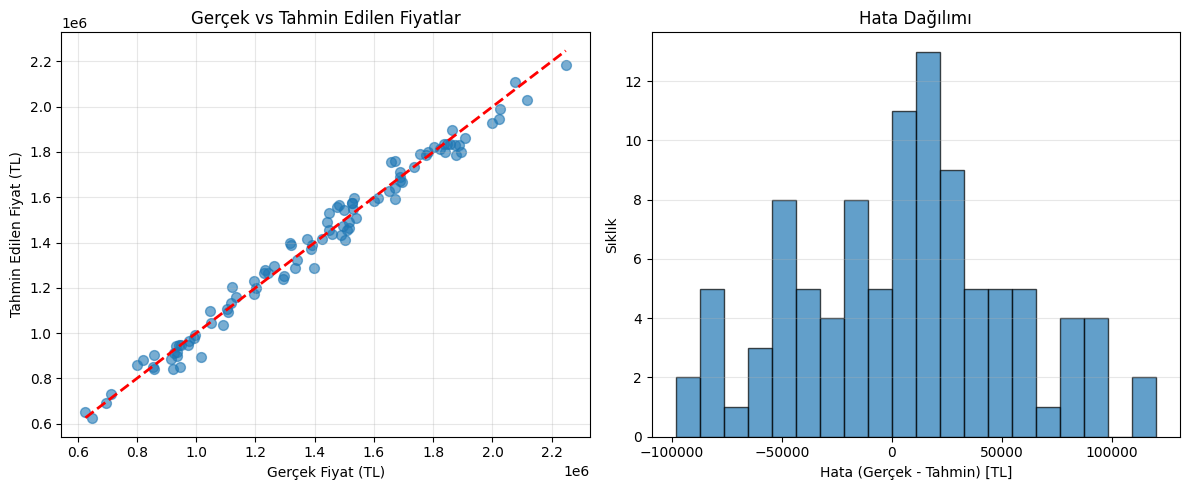


📈 Örnek Tahminler (Test Seti):


,Gerçek,Tahmin,Hata,Hata %
361,1.823247e+06,1.813517e+06,9729.866124,0.53
73,1.803571e+06,1.820578e+06,-17006.554746,0.94
374,1.121044e+06,1.204601e+06,-83557.088655,7.45
155,1.390116e+06,1.390113e+06,3.364978,0.00
104,1.502705e+06,1.412888e+06,89816.437359,5.98
394,1.656624e+06,1.754934e+06,-98309.550201,5.93
377,7.996499e+05,8.572414e+05,-57591.501713,7.20
124,9.405168e+05,9.486999e+05,-8183.035857,0.87
68,1.118451e+06,1.134140e+06,-15689.120630,1.40
450,1.457997e+06,1.437551e+06,20446.524397,1.40


In [ ]:
# Tahmin yap
y_pred = final_model.predict(X_test)

# Metrikler
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("MODEL SONUÇLARI")
print("-" * 40)
print(f"R² Skoru: {r2:.4f}")
print(f"MAE: {mae:,.2f} TL")
print(f"MSE: {mse:,.2f}")
print(f"RMSE: {rmse:,.2f} TL")
print("-" * 40)

# Görselleştirme
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Gerçek Fiyat')
plt.ylabel('Tahmin')
plt.title('Gerçek vs Tahmin')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
hatalar = y_test - y_pred
plt.hist(hatalar, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Hata')
plt.ylabel('Frekans')
plt.title('Hata Dağılımı')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Örnek karşılaştırma
print("\nÖrnek tahminler:")
karsilastirma = pd.DataFrame({'Gerçek': y_test[:10], 'Tahmin': y_pred[:10]})
karsilastirma['Fark'] = karsilastirma['Gerçek'] - karsilastirma['Tahmin']
display(karsilastirma)

---

## Modeli Kaydetme

Eğittiğim modeli pickle ile .pkl formatında kaydediyorum. Flask uygulamasında kullanacağım.

In [ ]:
# Model ve sütunları kaydet
model_data = {
    "model": final_model,
    "columns": X.columns.tolist()
}

with open("araba_modeli.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model kaydedildi: araba_modeli.pkl")
print(f"Sütunlar: {X.columns.tolist()}")

💾 MODEL KAYDEDİLİYOR...
✅ Model başarıyla kaydedildi!
   Dosya: araba_modeli.pkl
   Model Sütunları: ['Yil', 'Kilometre', 'Motor_Gucu', 'Hasar_Kaydi', 'Vites_Kod']


---

## Flask Web Uygulaması

app.py dosyasında Flask ile basit bir web arayüzü hazırladım. Kullanıcı araç bilgilerini girince fiyat tahmini yapılıyor.

In [ ]:
# Flask kodu örneği
flask_kodu = '''
from flask import Flask, request, render_template
import pickle
import pandas as pd

app = Flask(__name__)

# Model yükle
model_data = pickle.load(open('araba_modeli.pkl', 'rb'))
model = model_data['model']
model_columns = model_data['columns']

@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    yil = int(request.form['Yil'])
    km = int(request.form['Kilometre'])
    hp = int(request.form['Motor_Gucu'])
    hasar = int(request.form['Hasar_Kaydi'])
    vites = request.form['Vites']
    
    input_data = {col: 0 for col in model_columns}
    input_data['Yil'] = yil
    input_data['Kilometre'] = km
    input_data['Motor_Gucu'] = hp
    input_data['Hasar_Kaydi'] = hasar
    input_data['Vites_Kod'] = 1 if vites == 'Otomatik' else 0
    
    input_df = pd.DataFrame([input_data])[model_columns]
    fiyat = model.predict(input_df)[0]
    
    return render_template('index.html', prediction_text=f'Tahmini Fiyat: {fiyat:,.0f} TL')

if __name__ == "__main__":
    app.run(debug=True)
'''
print(flask_kodu)

SyntaxError: unterminated triple-quoted string literal (detected at line 53) (1320120863.py, line 24)

## Çalıştırma

Terminalde `python app.py` yazıp tarayıcıda `http://localhost:5000` adresine gidiyorum.

In [ ]:
print("Flask uygulamasını çalıştırmak için:")
print("1. Terminal aç")
print("2. python app.py yaz")
print("3. http://localhost:5000 adresine git")

---

## Sonuç

Backward elimination sonrası Renk değişkeni elendi çünkü p-value > 0.05 idi. Yani renk fiyatı etkilemiyor.

Kalan özellikler: Yıl, Kilometre, Motor Gücü, Hasar Kaydı, Vites

Model oldukça başarılı çıktı. R² değeri %98 civarında.

In [ ]:
print("PROJE ÖZET")
print("-" * 40)
print("1. Veri ön işleme yapıldı")
print("2. Kategorik veriler kodlandı")
print("3. Backward elimination uygulandı")
print("4. Model eğitildi")
print(f"5. R² = {r2:.4f}")
print(f"6. MAE = {mae:,.0f} TL")
print(f"7. MSE = {mse:,.0f}")
print("8. Model .pkl olarak kaydedildi")
print("9. Flask arayüzü hazırlandı")
print("-" * 40)